In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import minimize
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [7]:
class PortfolioAllocator:
    def __init__(self, lookback_period=252):
        self.lookback_period = lookback_period
        self.scaler = StandardScaler()
        self.rf_models = {}  # dictionary for each asset model
        self.load_data()
        
    def load_data(self):
        """load and prepare asset data"""
        # load data
        self.df = pd.read_csv('data/processed/merged_data.csv')
        self.df['Date'] = pd.to_datetime(self.df['Date'])
        self.df.set_index('Date', inplace=True)
        
        # investable assets definition
        self.investable_assets = {
            'US_Large_Cap': ['SPY_Close'],  # spy as main s&p 500 etf
            'US_Tech': ['QQQ_Close', 'XLK_Close'],  # tech sector etfs
            'Large_Tech_Stocks': ['MSFT_Close', 'GOOGL_Close', 'AMZN_Close'],
            'Growth_Stocks': ['TSLA_Close'],
            'Sectors': ['XLF_Close', 'XLV_Close'],  # financial and healthcare sectors
            'Fixed_Income': ['IEF_Close', 'TLT_Close'],  # treasury bonds
            'Commodities': ['GC=F_Close', 'CL=F_Close', 'SI=F_Close'],  # gold, oil, silver
            'Real_Estate': ['VNQ_Close'],  # real estate etf
            'Crypto': ['BTC_Close', 'ETH_Close']  # major cryptocurrencies
        }
        
        # market indicators for features (not for allocation)
        self.market_indicators = {
            'Indices': ['^GSPC_Close', '^IXIC_Close', '^DJI_Close', '^RUT_Close'],
            'Economic': ['GDP', 'CPI', 'FEDFUNDS', 'UNRATE', 'PPI']
        }
        
        # filter available assets
        self.assets = {
            asset_class: [asset for asset in assets if asset in self.df.columns]
            for asset_class, assets in self.investable_assets.items()
        }
        self.assets = {k: v for k, v in self.assets.items() if v}
        
        if not self.assets:
            raise ValueError("No matching investable assets found in the data file")

    def create_features(self, data):
        """create enhanced features including market indicators"""
        features = pd.DataFrame(index=data.index)
        
        # market indicator features
        for indicator_type, indicators in self.market_indicators.items():
            for indicator in indicators:
                if indicator in self.df.columns:
                    if indicator_type == 'Economic':
                        # normalize economic indicators
                        features[f'{indicator}_norm'] = self.df[indicator]
                    else:
                        # calculate returns for market indices
                        features[f'{indicator}_return'] = self.df[indicator].pct_change()
        
        # technical indicators for investable assets
        for asset_class, assets in self.assets.items():
            for asset in assets:
                prices = data[asset]
                
                # enhanced momentum features
                features[f'{asset}_MOM5'] = prices.pct_change(periods=5)
                features[f'{asset}_MOM10'] = prices.pct_change(periods=10)
                features[f'{asset}_MOM20'] = prices.pct_change(periods=20)
                
                # volatility features
                returns = prices.pct_change()
                features[f'{asset}_VOL10'] = returns.rolling(window=10).std()
                features[f'{asset}_VOL20'] = returns.rolling(window=20).std()
                
                # trend features
                features[f'{asset}_MA10'] = prices.rolling(window=10).mean() / prices - 1
                features[f'{asset}_MA20'] = prices.rolling(window=20).mean() / prices - 1
                features[f'{asset}_MA50'] = prices.rolling(window=50).mean() / prices - 1
                
                # rsi
                delta = prices.diff()
                gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
                loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
                rs = gain / loss
                features[f'{asset}_RSI'] = 100 - (100 / (1 + rs))
        
        # cross-asset correlation features
        for asset1 in data.columns:
            for asset2 in data.columns:
                if asset1 < asset2:  # avoid duplicates
                    corr = data[asset1].rolling(30).corr(data[asset2])
                    features[f'corr_{asset1}_{asset2}'] = corr
        
        # regime detection features
        for asset in data.columns:
            # volatility regime
            returns = data[asset].pct_change()
            vol = returns.rolling(20).std()
            features[f'{asset}_vol_regime'] = (vol > vol.rolling(100).mean()).astype(int)
            
            # momentum regime using multiple timeframes
            for period in [5, 21, 63]:  # 1 week, 1 month, 3 months
                mom = data[asset].pct_change(period)
                features[f'{asset}_mom_{period}'] = (mom > 0).astype(int)
                
            # mean reversion signals
            for period in [5, 10, 20]:
                zscore = (data[asset] - data[asset].rolling(period).mean()) / data[asset].rolling(period).std()
                features[f'{asset}_zscore_{period}'] = zscore
        
        return features.dropna()

    def prepare_ml_data(self, data, target_col):
        """prepare data for ml models"""
        features = self.create_features(data)
        
        # prepare target (future returns)
        target = data[target_col].pct_change().shift(-1).dropna()
        
        # align features and target
        features = features[:-1]
        target = target[features.index]
        
        # scale features
        scaled_features = self.scaler.fit_transform(features)
        
        return scaled_features, target.values, features

    def train_models(self, data):
        """train random forest models"""
        portfolio_assets = []
        for assets in self.assets.values():
            portfolio_assets.extend(assets)
            
        for asset in portfolio_assets:
            # prepare data
            features, target, _ = self.prepare_ml_data(data, asset)
            
            # new model for each asset
            self.rf_models[asset] = RandomForestRegressor(n_estimators=100, random_state=42)
            self.rf_models[asset].fit(features, target)

    def predict_returns(self, features, asset):
        """enhanced return prediction with regime awareness"""
        scaled_features = self.scaler.transform(features)
        
        # base predictions
        rf_pred = self.rf_models[asset].predict(scaled_features)
        
        # regime-based adjustments
        vol_regime = features[f'{asset}_vol_regime'].iloc[-1]
        mom_regime = features[f'{asset}_mom_21'].iloc[-1]
        zscore = features[f'{asset}_zscore_20'].iloc[-1]
        
        # adjust predictions based on regimes
        regime_adjustment = 0.0
        if vol_regime == 1:  # high volatility
            regime_adjustment -= 0.002  # reduce exposure
        if mom_regime == 1:  # positive momentum
            regime_adjustment += 0.003
        if abs(zscore) > 2:  # mean reversion opportunity
            regime_adjustment += -np.sign(zscore) * 0.002
        
        # final prediction with regime adjustment
        final_pred = rf_pred + regime_adjustment
        return final_pred

    def calculate_ml_metrics(self, prices):
        """calculate return metrics using ml predictions"""
        features = self.create_features(prices)
        prediction_horizon = 252
        
        predicted_returns = pd.Series(index=prices.columns)
        for asset in prices.columns:
            # daily predictions for the horizon
            daily_predictions = []
            current_features = features.copy()
            
            for day in range(prediction_horizon):
                # next day
                day_pred = self.predict_returns(current_features, asset)
                daily_predictions.append(day_pred)
                
                # update features for next prediction
                current_features = current_features.shift(1)
            
            # compound  daily returns
            horizon_return = np.prod(1 + np.array(daily_predictions)) - 1
            predicted_returns[asset] = horizon_return
        
        # annualize returns
        predicted_returns = (1 + predicted_returns) ** (252/prediction_horizon) - 1
        
        # risk calculation
        returns = prices.pct_change()
        cov_matrix = returns.cov() * 252
        
        return predicted_returns, cov_matrix

    def calculate_dynamic_bounds(self, historical_data, expected_returns):
        """calculate dynamic bounds based on historical performance and risk metrics"""
        bounds = []
        returns = historical_data.pct_change()
        
        # key metrics for each asset
        metrics = {}
        for asset in historical_data.columns:
            asset_returns = returns[asset].dropna()
            metrics[asset] = {
                'volatility': asset_returns.std() * np.sqrt(252),  # annualized volatility
                'sharpe': (asset_returns.mean() * 252) / (asset_returns.std() * np.sqrt(252)),
                'max_drawdown': (historical_data[asset] / historical_data[asset].expanding().max() - 1).min(),
                'beta': asset_returns.cov(returns['SPY_Close']) / returns['SPY_Close'].var()
            }
        
        for asset in expected_returns.index:
            asset_metrics = metrics[asset]
            
            # base allocation range on risk-adjusted metrics
            base_weight = 1 / len(expected_returns)  # equal weight starting point
            
            # adjust bounds based on asset characteristics
            vol_factor = 1 / (1 + asset_metrics['volatility'])  # lower vol -> higher allocation
            sharpe_factor = (1 + asset_metrics['sharpe']) / 2  # higher sharpe -> higher allocation
            beta_factor = 1 / (1 + abs(asset_metrics['beta']))  # more moderate beta -> higher allocation
            
            # combine factors
            adjustment_factor = (vol_factor + sharpe_factor + beta_factor) / 3
            
            # min and max bounds
            min_bound = max(0, base_weight * adjustment_factor * 0.5)
            max_bound = min(0.4, base_weight * adjustment_factor * 2)
            
            # asset-specific adjustments based on type
            if 'Crypto' in asset:
                max_bound = min(max_bound, 0.1)  # cap crypto exposure
            elif 'Fixed_Income' in asset:
                min_bound = max(min_bound, 0.05)  # ensure some bond exposure
            elif 'US_Large_Cap' in asset:
                min_bound = max(min_bound, 0.05)  # ensure some market exposure
                
            bounds.append((min_bound, max_bound))
            
        return bounds

    def optimize_portfolio(self, expected_returns, risk_matrix):
        """enhanced portfolio optimization with dynamic risk management"""
        n_assets = len(expected_returns)
        
        # dynamic bounds based on recent data
        portfolio_assets = []
        for assets in self.assets.values():
            portfolio_assets.extend(assets)
        recent_data = self.df[portfolio_assets].tail(self.lookback_period)
        bounds = self.calculate_dynamic_bounds(recent_data, expected_returns)
        
        # dynamic risk target based on market conditions
        vol_regime = self.df['SPY_Close'].pct_change().rolling(20).std().iloc[-1]
        risk_target = 0.15 if vol_regime < 0.02 else 0.10  # adjust risk based on volatility
        
        def objective(weights):
            portfolio_return = np.sum(weights * expected_returns)
            portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(risk_matrix, weights)))
            
            # enhanced objective function with risk-adjusted return
            if portfolio_risk > risk_target:
                return -(portfolio_return / portfolio_risk)
            else:
                return -portfolio_return
        
        # minimum return constraint
        min_return = max(expected_returns.max() * 0.5, 0.05)  # target at least 50% of best asset return
        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'ineq', 'fun': lambda x: np.sum(x * expected_returns) - min_return}
        ]
        
        result = minimize(objective,
                         x0=np.array([1/n_assets] * n_assets),
                         method='SLSQP',
                         bounds=bounds,
                         constraints=constraints)
        
        return pd.Series(result.x, index=expected_returns.index)

    def generate_allocation(self, risk_tolerance=0.15):
        """generate ml-enhanced portfolio allocation"""
        portfolio_assets = []
        for asset_class in self.assets.values():
            portfolio_assets.extend(asset_class)
            
        recent_data = self.df[portfolio_assets].tail(self.lookback_period)
        
        self.train_models(recent_data)
        
        # ml-enhanced predictions
        expected_returns, cov_matrix = self.calculate_ml_metrics(recent_data)
        
        # optimize portfolio
        weights = self.optimize_portfolio(expected_returns, cov_matrix)
        
        return pd.Series(weights, index=portfolio_assets)

    def get_current_allocation(self):
        """get current recommended portfolio allocation"""
        allocation = self.generate_allocation()
        
        formatted_allocation = {}
        for asset_class, assets in self.assets.items():
            class_allocation = allocation[assets].sum()
            formatted_allocation[asset_class] = round(class_allocation * 100, 2)
            
        return pd.Series(formatted_allocation)

    def evaluate_portfolio_performance(self, start_date=None, end_date=None):
        """compare portfolio performance with s&p 500 benchmark"""
        weights = self.generate_allocation()
        
        if start_date is None:
            start_date = self.df.index[-252]  # default to last year
        if end_date is None:
            end_date = self.df.index[-1]
            
        if isinstance(start_date, str):
            start_date = pd.to_datetime(start_date)
        if isinstance(end_date, str):
            end_date = pd.to_datetime(end_date)
            
        mask = (self.df.index >= start_date) & (self.df.index <= end_date)
        period_data = self.df[mask]
        
        # portfolio returns
        portfolio_assets = []
        for assets in self.assets.values():
            portfolio_assets.extend(assets)
        
        asset_returns = period_data[portfolio_assets].pct_change()
        portfolio_returns = (asset_returns * weights).sum(axis=1)
        portfolio_cumulative = (1 + portfolio_returns).cumprod()
        
        # s&p 500 returns (using spy as proxy)
        spy_returns = period_data['SPY_Close'].pct_change()
        spy_cumulative = (1 + spy_returns).cumprod()
        
        # plot the comparison
        plt.figure(figsize=(12, 6))
        plt.plot(portfolio_cumulative.index, portfolio_cumulative, label='Portfolio', linewidth=2)
        plt.plot(spy_cumulative.index, spy_cumulative, label='S&P 500', linewidth=2)
        
        plt.title('Portfolio Performance vs S&P 500')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.legend()
        plt.grid(True)
        
        # performance metrics
        portfolio_total_return = portfolio_cumulative.iloc[-1] - 1
        spy_total_return = spy_cumulative.iloc[-1] - 1
        
        print(f"\nPerformance Metrics ({start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')})")
        print(f"Portfolio Total Return: {portfolio_total_return:.2%}")
        print(f"S&P 500 Total Return: {spy_total_return:.2%}")
        
        plt.show()

    def plot_portfolio_insights(self):
        """portfolio visualizations"""
        allocation = self.get_current_allocation()
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # pie chart of current allocation
        ax1.pie(allocation, labels=allocation.index, autopct='%1.1f%%')
        ax1.set_title('Current Portfolio Allocation')

        # asset class historical volatility
        portfolio_assets = []
        for assets in self.assets.values():
            portfolio_assets.extend(assets)
        
        recent_data = self.df[portfolio_assets].tail(252)  # last year
        volatilities = recent_data.pct_change().std() * np.sqrt(252)  # annualized volatility
        volatilities.sort_values().plot(kind='barh', ax=ax2)
        ax2.set_title('Asset Volatility (Annual)')
        ax2.set_xlabel('Volatility')

        # rolling correlation with s&p 500
        correlations = {}
        spy_returns = self.df['SPY_Close'].pct_change()
        for asset in portfolio_assets:
            asset_returns = self.df[asset].pct_change()
            corr = asset_returns.rolling(window=60).corr(spy_returns).iloc[-1]  # last 60-day correlation
            correlations[asset] = corr
        
        pd.Series(correlations).sort_values().plot(kind='barh', ax=ax3)
        ax3.set_title('60-Day Correlation with S&P 500')
        ax3.set_xlabel('Correlation')

        # recent performance comparison
        recent_returns = recent_data.pct_change().mean() * 252  # annualized returns
        recent_returns.sort_values().plot(kind='barh', ax=ax4)
        ax4.set_title('Asset Returns (Annual)')
        ax4.set_xlabel('Return')

        plt.tight_layout()
        plt.show()

In [8]:
allocator = PortfolioAllocator()
allocation = allocator.get_current_allocation()
print("\nPortfolio Allocation (Random Forest):")
print(allocation)


Portfolio Allocation (Random Forest):
US_Large_Cap          5.88
US_Tech              11.76
Large_Tech_Stocks    17.65
Growth_Stocks         5.88
Sectors              11.76
Fixed_Income         11.76
Commodities          17.65
Real_Estate           5.88
Crypto               11.76
dtype: float64


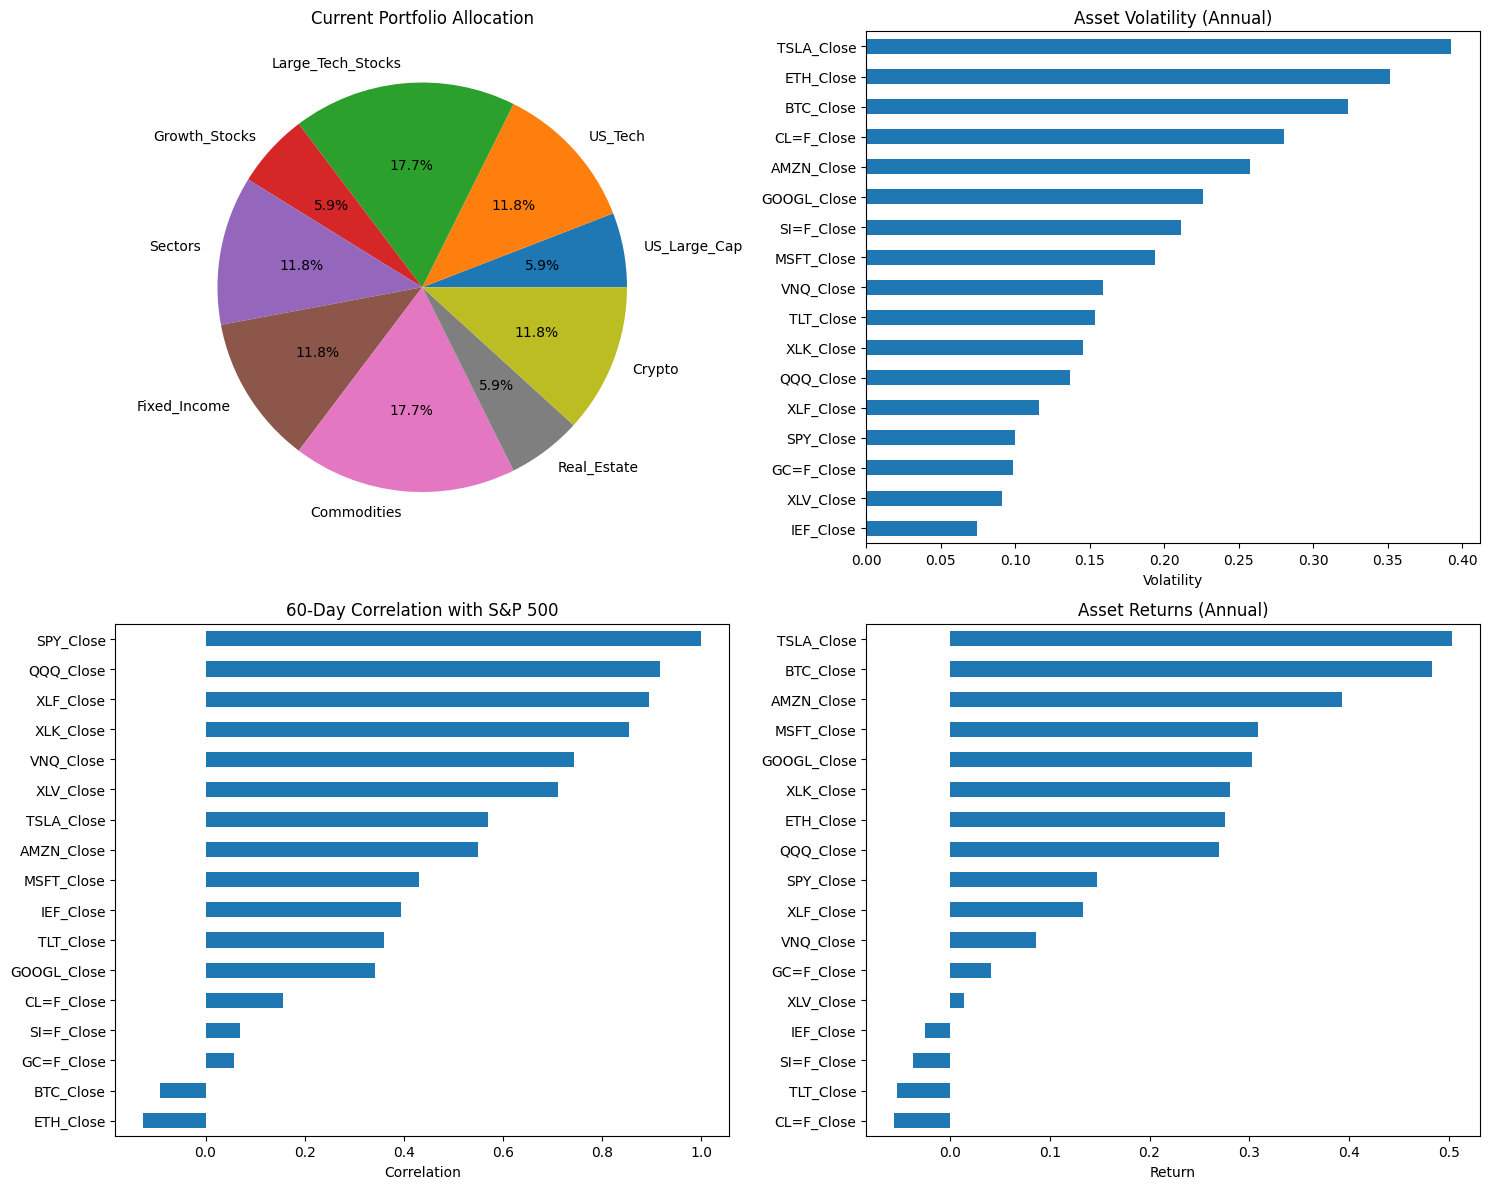

In [9]:
# visualization
allocator.plot_portfolio_insights()


Evaluating performance over the same period used for allocation:
From: 2022-12-31
To: 2023-12-31

Performance Metrics (2022-12-31 to 2023-12-31)
Portfolio Total Return: 38.81%
S&P 500 Total Return: 24.29%


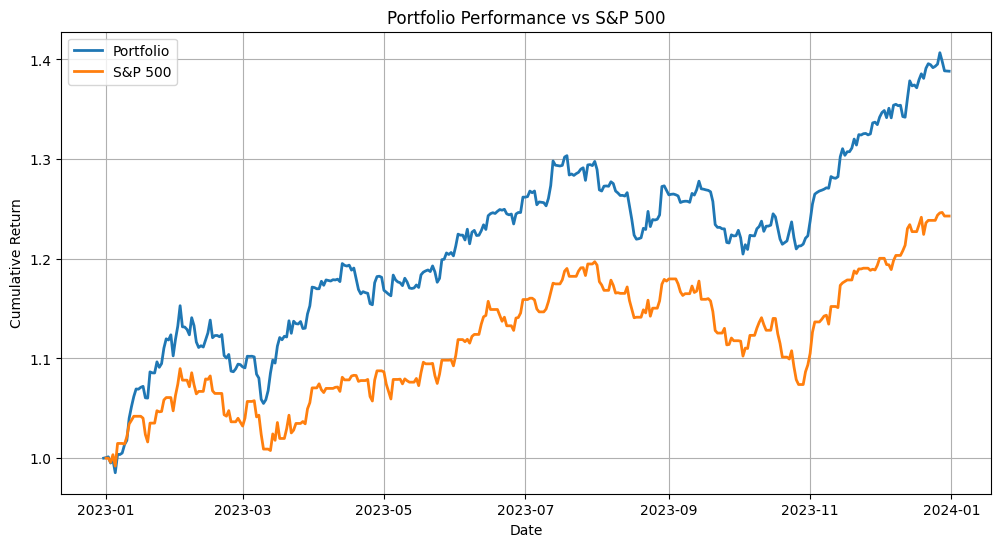

In [11]:
# performance evaluation

print(f"\nEvaluating performance over the same period used for allocation:")
print(f"From: 2022-12-31")
print(f"To: 2023-12-31")

# performance evaluation for just the last 252 days
allocator.evaluate_portfolio_performance(start_date='2022-12-31', end_date='2023-12-31')